# Milestone 2: Data wrangling and initial analyses

### Table of Contents

* [Section 0](#section0): Imports
* [Section 1](#section1): Familiarization with CMU Movie Summary Corpus dataset and restructuration
    * [Section 1.1](#section_1_1): Character metadata
    * [Section 1.2](#section_1_2): Movie metadata
    * [Section 1.3](#section_1_3): Plot summaries
    * [Section 1.4](#section_1_4): Core NLP plot summaries
    * [Section 1.5](#section_1_5): tvtropes_clusters
* [Section 2](#section2): Familiarization with IMDb dataset and restructuration
    * [Section 2.1](#section_2_1): Titles principals
    * [Section 2.2](#section_2_2): Name basics
    * [Section 2.3](#section_2_3): Title crew
    * [Section 2.4](#section_2_4): Title basics
    * [Section 2.5](#section_2_5): Title rankings
    * [Section 2.6](#section_2_6): Linking IMDb Ids to freebase movie Ids
* [Section 3](#section3): Initial analysis
    * [Section 3.1](#section_3_1): Most common actions of characters in the summaries
    * [Section 3.2](#section_3_2): Are women younger in cinema ?
    * [Section 3.3](#section_3_3): Differences between genres
    * [Section 3.4](#section_3_4): Difference in importance of movie roles women and men get
    * [Section 3.5](#section_3_5): Are IMDb ratings representing somewhat more male or female opinion on movie ?

## 0. Imports  <a class="anchor" id="section0"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
from wordcloud import WordCloud, STOPWORDS
import gzip
from pylab import xticks
import tqdm.notebook 
from tqdm.notebook import trange
import pickle
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px

### Usefull statistical functions

In [2]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

## 1.  Familiarization with CMU Movie Summary Corpus dataset and restructuration <a class="anchor" id="section1"></a>

In this section, we familiarize ourselves with the CMU Movie Summary Corpus dataset. We also restructure the data to make it directly usable for our future analysis.

### 1.1 Character metadata <a class="anchor" id="section_1_1"></a>

In [4]:
#Importing character metadata
df_char_meta = pd.read_table("./data/MovieSummaries/character.metadata.tsv", header=None)
df_char_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "character name", "Actor date of birth", "Actor gender", 
            "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", 
            "Freebase character ID", "Freebase actor ID"]

In [3]:
df_char_meta.sample(5)

,Wikipedia movie ID,Freebase movie ID,Movie release date,character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
368077,7972076,/m/026lz_k,2006-03-10,Christy,1985-08-27,M,NaN,NaN,Augustin Kennady,20.0,/m/02vcbqj,/m/0l68mkk,/m/0h1p4b
272275,33012483,/m/0b06ny,1940,NaN,1911-08-12,M,NaN,NaN,Cantinflas,28.0,/m/0jt36w,NaN,/m/013q78
367681,19868507,/m/04q9l98,2008,NaN,1941-10-10,M,1.905,/m/013b7g,Peter Coyote,66.0,/m/0n662rf,NaN,/m/02r34n
246681,11449217,/m/02rd16v,1914-03-02,NaN,1887-03-24,M,1.780,/m/07bch9,Roscoe Arbuckle,NaN,/m/03kzg9t,NaN,/m/0k57l
12808,28354779,/m/0cg316q,2009,Victor,1991-03-08,M,1.750,NaN,Devon Werkheiser,17.0,/m/0cgnlrv,/m/0h2_4_l,/m/04xbtl


In [4]:
print("Total size of the dataset: " + str(df_char_meta.shape[0]))

Total size of the dataset: 450669


In [5]:
print("Number of entries for which we don't have the gender: " + str(df_char_meta["Actor gender"].isnull().values.sum()))


Number of entries for which we don't have the gender: 45609


In [6]:
print("Number of entries for which we don't have the age at the movie release date: " + 
      str(df_char_meta["Actor age at movie release"].isnull().values.sum()))

Number of entries for which we don't have the age at the movie release date: 158113


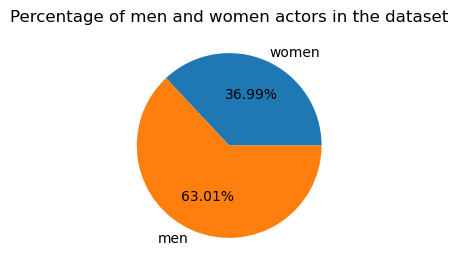

In [7]:
mylabels = ["women", "men"]
plt.figure(figsize=(3,3)) 
plt.pie(np.array([df_char_meta[df_char_meta['Actor gender'] == 'F']['Actor name'].nunique(),df_char_meta[df_char_meta['Actor gender'] == 'M']['Actor name'].nunique()]), labels = mylabels, autopct='%1.2f%%')
plt.title("Percentage of men and women actors in the dataset")
plt.show()

### 1.2 Movie metadata <a class="anchor" id="section_1_2"></a>

In [9]:
#Importing the data
df_movie_meta = pd.read_table("./data/MovieSummaries/movie.metadata.tsv", header=None)
df_movie_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", 
                     "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries", "Movie genres"]


In [9]:
#Creating lists in desired columns
df_movie_meta['Movie countries'] = df_movie_meta['Movie countries'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie countries'] = df_movie_meta['Movie countries'].apply(lambda x: list(x.values()))
df_movie_meta['Movie genres'] = df_movie_meta['Movie genres'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie genres'] = df_movie_meta['Movie genres'].apply(lambda x: list(x.values()))
df_movie_meta['Movie languages'] = df_movie_meta['Movie languages'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie languages'] = df_movie_meta['Movie languages'].apply(lambda x: list(x.values()))

In [10]:
#Keeping only the year of the movie
df_movie_meta.query("`Movie release date` > '1915'", inplace = True)
df_movie_meta["Movie release date"] = pd.to_datetime(df_movie_meta["Movie release date"])
df_movie_meta["Movie release date"] = df_movie_meta["Movie release date"].dt.year

In [11]:
df_movie_meta.sample(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
24281,31830066,/m/0gtwfdp,Shaheb Name Golam,2009,NaN,NaN,[Bengali Language],[Bangladesh],[Family Drama]
56781,26930909,/m/09n9rcv,Hell's Highway,1932,NaN,62.0,[English Language],[United States of America],[Drama]
2574,26293153,/m/0b745m7,The Big Operator,1959,NaN,91.0,[English Language],[United States of America],"[Crime Fiction, Drama]"
67192,3644025,/m/09rvwv,Flesh for Frankenstein,1974,NaN,95.0,[English Language],"[France, United States of America, Italy]","[Science Fiction, Horror, Indie, Creature Film..."
11598,36183483,/m/0g519bh,The Lion Roars,2002,NaN,98.0,[Cantonese],[Hong Kong],"[Comedy film, Chinese Movies]"


Text(0.5, 1.0, 'Number of movies released each year')

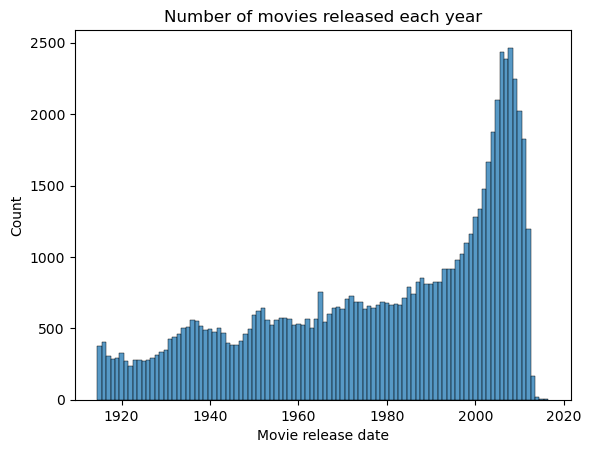

In [12]:
sns.histplot(df_movie_meta['Movie release date'], discrete = True)
plt.title('Number of movies released each year')

We see that the number of movies available in the dataset increase slowly between the 1920s and then 1990s increases exponentially starting 1990.

Text(0.5, 1.0, 'Top movie coutries')

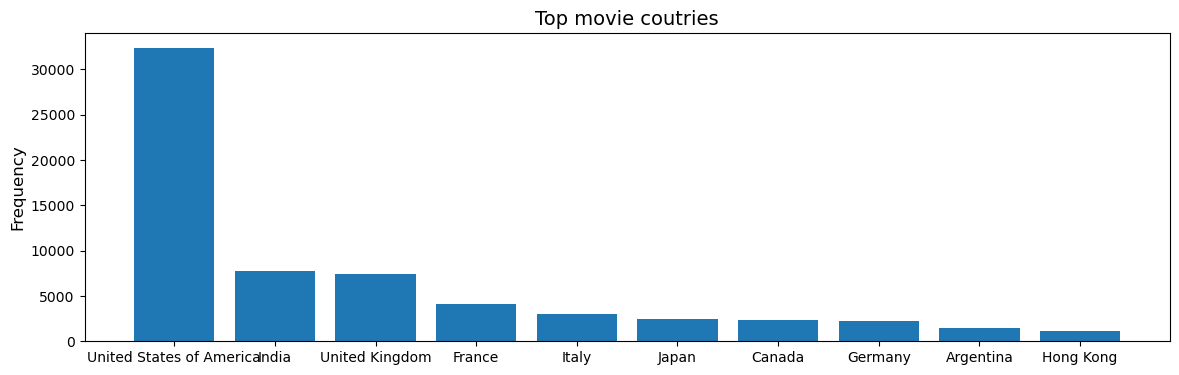

In [13]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
a = to_1D(df_movie_meta['Movie countries']).value_counts().nlargest(10)

fig, ax = plt.subplots(figsize = (14,4))
ax.bar(a.index,
        a.values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Top movie coutries", size = 14)

Text(0.5, 1.0, 'Top genres')

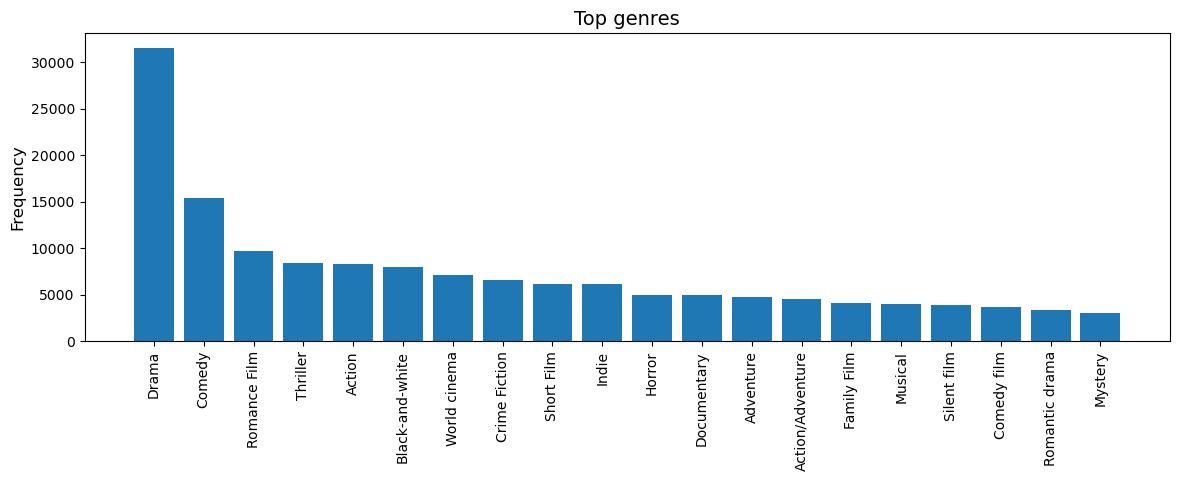

In [14]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

a = to_1D(df_movie_meta['Movie genres']).value_counts().nlargest(20)

fig, ax = plt.subplots(figsize = (14,4))
ax.bar(a.index,
        a.values)
plt.xticks(rotation=90)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Top genres", size = 14)

#### Merging and cleaning the two datasets

In [15]:
df_merged_meta = pd.DataFrame(df_char_meta[["Freebase movie ID", "Actor gender", "Actor age at movie release"]])
df_merged_meta = pd.merge(df_merged_meta, df_movie_meta[["Freebase movie ID", "Movie release date", 
                                                        "Movie countries", "Movie genres"]], on="Freebase movie ID")

In [59]:
df_merged_meta.sample(5)

,Freebase movie ID,Actor gender,Actor age at movie release,Movie release date,Movie countries,Movie genres
433981,/m/02q1jgf,M,73.0,1983,[India],"[Musical, Action, Drama]"
173109,/m/06_wdx9,M,33.0,1965,[India],"[Drama, Tollywood]"
365076,/m/0bbbmbf,M,45.0,1951,[France],[Drama]
59551,/m/04gsth2,F,19.0,1962,[India],"[Musical, Drama]"
327982,/m/0cjwkt,M,24.0,1935,[United States of America],[Black-and-white]


In [17]:
print("Size of the gloabal dataset: " + str(df_merged_meta.shape[0]))
df_merged_meta.dropna(subset=['Actor gender'], inplace = True)
print("Size after removing entries with no gender: " + str(df_merged_meta.shape[0]))
df_merged_meta.dropna(subset=['Actor age at movie release'], inplace = True)
print("Size after removing entries with no age at movie release: " + str(df_merged_meta.shape[0]))

Size of the gloabal dataset: 437830
Size after removing entries with no gender: 392446
Size after removing entries with no age at movie release: 290726


### 1.3 Plot summaries <a class="anchor" id="section_1_3"></a>
A dataframe that with 60000 summaries from movies.

In [7]:
PLOT_SUMMARIES = './data/MovieSummaries/plot_summaries.txt'
plot_summaries = pd.read_csv(PLOT_SUMMARIES, sep="\t", header=None, names = ['Wikipedia movie ID','summary'])

In [17]:
plot_summaries.sample(5)

,Wikipedia movie ID,summary
23103,23666645,"The young Michèle Isola, who is about to inher..."
17850,13822832,"The title character is Victor Church, a World ..."
29078,27869241,Daffy scoffs at a flock of ducks flying south ...
29360,24480416,The documentary follows the life of 11 male pr...
21029,20435857,Nitin Bankar and Ram Mishra are lucky in lov...


### 1.4 Core NLP plot summaries <a class="anchor" id="section_1_4"></a>

The code below show how, from the file "corenlp_plot_summaries", we get all dependencies associated with all characters in every movie. We then put them in a dataframe. Since the loops are very long to run, we store it into a csv file called 'characters_descriptions.csv'.

In [ ]:
## we will build the dataframe that will store all the words, actions 
## associated with each character from each movie

## we get all the movie ids
movie_ids = character_md.drop_duplicates('Wikipedia movie ID')['Wikipedia movie ID']

## we pre-allocate the list so loops goes faster, 
## because append function is slower
SIZE = 5000000
dependency = [None] * SIZE
governor = [None] * SIZE
dependent = [None] * SIZE
actor_name = [None] * SIZE
actor_id = [None] * SIZE
actor_gender = [None] * SIZE
char_name = [None] * SIZE
action = [None] * SIZE
movie_Id = [None] * SIZE

## start loop over each movie
## i index for each movie
## j index for the number of actions registered, we use it to store data in lists
i = 0
j = 0
for movie_id in movie_ids:
    
    ## to have an idea of the advancement of the process
    '''
    if (i%1000 == 0) & (i>1000):
        print(round(i*100/len(movie_ids), 2))
    i +=1
    '''
    
    ## we open the file in relation to this movie_id
    
    PATH = './data/MovieSummaries/corenlp_plot_summaries/' + str(movie_id) + '.xml.gz'
    
    try: 
        UNZIP_PATH = gzip.open(PATH, 'r')
        tree = ET.parse(UNZIP_PATH)
        root = tree.getroot()
    except:
        ## Some movies in the data base don't have a resume that have 
        ## been processed by the stanford coreNLP program.
        ## We just skip loop for these movies
        continue
        
    ## we get all the characters in the corresponding movie
    characters = character_md[character_md['Wikipedia movie ID'] == movie_id].dropna(subset=['Character name'])
    
    ## start loop over all dependencies (i.e. links between words in the resume)
    for child in root.iter('dep'):
        
        typ = child.attrib['type']
        gov = child[0].text
        dep = child[1].text
        
        ## start loop over all characters in the movie
        for idx, prsn in characters.iterrows():
    
            chn = prsn['Character name']
            actorname = prsn['Actor name']
            actorid = prsn['Freebase actor ID']
            actorgender = prsn['Actor gender']
            
            ## often, a character is called by only a part of its name, 
            ## we have to take it into account.
            for chn_ in chn.split():
                ## if one of the words is related to the character,
                ## we store the dependency in the lists
                if (chn_ == gov) | (chn_ == dep):
                    actor_name[j] = actorname
                    actor_id[j] = actorid
                    actor_gender[j] = actorgender
                    char_name[j] = chn
                    dependency[j] = typ
                    governor[j] = gov
                    dependent[j] = dep
                    movie_Id[j] = movie_id
                    if chn_ == gov:
                        action[j] = dep
                    else:
                        action[j] = gov
                    j+=1
                    
## We create the dataframe from those lists, and then store it into a csv file                  
actor_words = pd.DataFrame.from_dict({'actor name' : actor_name[:j], 'actor id' : actor_id[:j], 'actor gender' : actor_gender[:j], 'character name' : char_name[:j], 'dependency':dependency[:j], 'governor':governor[:j], 'dependent':dependent[:j], 'action' : action[:j], 'movie id': movie_Id[:j]})
actor_words.to_csv('characters_descriptions.csv', index=False)

let's look at the dataframe created

In [20]:
characters_descriptions = pd.read_csv('./data/MovieSummaries/characters_descriptions.csv')

In [23]:
## a description of the data frame
print('This dataframe contains all the actions associated with every character in every movie resumes. \nColumns about ids will be usefull for merging action with other dataframes.')
print('number of rows : ' + str(characters_descriptions.shape[0]))
characters_descriptions.sample(5)

This dataframe contains all the actions associated with every character in every movie resumes. 
Columns about ids will be usefull for merging action with other dataframes.
number of rows : 2561042


,actor name,actor id,actor gender,character name,dependency,governor,dependent,action,movie id
2167883,Michael McElroy,/m/02pkcmz,M,Ben Cappadora - Age 3,cc,Cappadora,and,and,12978934
2085644,Anupam Kher,/m/0292l3,M,Saxena,appos,Saxena,daughter,daughter,1413739
42276,Jacqueline Obradors,/m/04jlpk,F,Angelica,agent,accompanied,Angelica,accompanied,365039
2515959,Kurt Russell,/m/01g969,M,Dexter Riley,dobj,sees,Dexter,sees,9613521
1679667,Graham McTavish,/m/027nbx1,M,Loki,dobj,takes,Loki,takes,18373306


As we can see, we've stored the most relevant information to us in order to later maybe merge this dataframe with other ones to mix data and make analysis. 
Each row correspond to an action or description of a character in a movie. In consequence, we have columns storing inforamtions about the character, the actor, and the movie. 

### 1.5 tvtropes_clusters <a class="anchor" id="section_1_5"></a>
tvtropes_cluster is a dataframe that stores some character profiles that are redundant in movies. They associate these characters profiles with characters, actors and the movie

In [15]:
TVTROPES_CLUSTERS = "./data/MovieSummaries/tvtropes.clusters.txt"
tvtropes_clusters = pd.read_csv(TVTROPES_CLUSTERS, sep="\t", header=None, names = ['char types', 'char', 'movie', 'ID', 'actor'])
dic = tvtropes_clusters.to_dict()
for idx in range(tvtropes_clusters.shape[0]):
    serie = json.loads(dic['char'][idx])
    tvtropes_clusters.at[idx, 'char'] = serie['char']
    tvtropes_clusters.at[idx, 'movie'] = serie['movie']
    tvtropes_clusters.at[idx, 'ID'] = serie['id']
    tvtropes_clusters.at[idx, 'actor'] = serie['actor']
tvtropes_clusters.sample(5)

,char types,char,movie,ID,actor
130,coward,Beni Gabor,The Mummy,/m/03jskk3,Kevin J. O'Connor
55,bromantic_foil,Banky Edwards,Chasing Amy,/m/05ckj7h,Jason Lee
442,stoner,Thadeous,Your Highness,/m/07zm_ym,Danny McBride
458,surfer_dude,Geek,Surf's Up,/m/02_wz9s,Jeff Bridges
340,loveable_rogue,Peter Blood,Captain Blood,/m/02vb_m3,Errol Flynn


## 2. Familiarization with IMDb dataset and restructuration <a class="anchor" id="section2"></a>

In [4]:
data_folder_IMDB = './IMDb data/'

In this section, we familiarize ourselves with the IMDb dataset. We select the useful data for our future analysis.

### 2.1 Titles principals <a class="anchor" id="section_2_1"></a>

In [19]:
f = gzip.open(data_folder_IMDB + './title.principals.tsv.gz','rb')
df_titles_principal = pd.read_csv(f, sep='\t')
df_titles_principal.head(5)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [20]:
df_titles_principal['category'].unique()

array(['self', 'director', 'cinematographer', 'composer', 'producer',
       'editor', 'actor', 'actress', 'writer', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

We see that IMDb dataset differentiates actresses from actors, but does not for the other jobs. We are interested genders of actors, writers, producers, directors, so we query them using SQL.

SELECT 
  ?id
  ?gender
  ?IMDb_ID 

WHERE 
{
  ?id p:P345 ?id2.
  ?id wdt:P21 ?gender. 
  ?id wdt:P345 ?IMDb_ID.
}

In [21]:
gender_imdb = pd.read_csv('imdb_genders.csv')
gender_imdb['gender'] = gender_imdb['gender'].apply(lambda x : str(x).rsplit('/', 1)[-1])
gender_imdb = gender_imdb.drop(columns = ['id'])
gender_imdb.head(5)

,gender,IMDb_ID
0,Q6581097,nm0899581
1,Q6581097,nm2561320
2,Q6581097,nm0005240
3,Q6581097,nm0707199
4,Q6581097,nm1211443


Now we replace wikidata ids by the gender (male = Q6581097 and female = Q6581072). Category "actress" gets gender female and category "actor" gets gender male. We discard trangender people, two-spirit, genderqueer, bigender people and all very singular genre attributes because of their rarity.

In [22]:
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581097', 'male')
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581072', 'female')
gender_imdb = gender_imdb[gender_imdb['gender'].str.contains('male|female')]

In [23]:
gender_imdb.head(5)

,gender,IMDb_ID
0,male,nm0899581
1,male,nm2561320
2,male,nm0005240
3,male,nm0707199
4,male,nm1211443


In [24]:
gender_imdb['gender'].value_counts()

male      280097
female    146461
Name: gender, dtype: int64

Now let's merge the two dataframes based on the IMDb id.

In [25]:
df_titles_principal = df_titles_principal.merge(gender_imdb, how= 'left', left_on = 'nconst', right_on = 'IMDb_ID')

In [26]:
df_titles_principal.head(5)

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658
3,tt0000002,1,nm0721526,director,\N,\N,male,nm0721526
4,tt0000002,2,nm1335271,composer,\N,\N,NaN,NaN


We add the information coming from actress/actor to the gender column :

In [27]:
df_titles_principal.gender.fillna(df_titles_principal.category, inplace=True)
df_titles_principal['gender'] = df_titles_principal['gender'].str.replace('actress', 'female')
df_titles_principal['gender'] = df_titles_principal['gender'].str.replace('actor', 'male')
df_titles_principal = df_titles_principal[df_titles_principal['gender'].str.contains('male|female')]

In [28]:
df_titles_principal = df_titles_principal.drop_duplicates()
df_titles_principal.head(3)

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658


In [29]:
#creates a file
picklefile = open('df_titles_principal_with_gender', 'wb')
#pickles the dataframe
pickle.dump(df_titles_principal, picklefile)

### 2.2 Name basics <a class="anchor" id="section_2_2"></a>

From this file, we keep the birth year and the primary name and merge with the previous dataset.

In [30]:
picklefile = open('df_titles_principal_with_gender', 'rb')
#unpickle the dataframe
df_titles_principal = pickle.load(picklefile)
df_titles_principal.head(3)

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658


In [31]:
f=gzip.open(data_folder_IMDB + './name.basics.tsv.gz','rb')
df_name_basics = pd.read_csv(f, sep='\t')
df_name_basics.head(3)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0050419,tt0072308,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345"


In [32]:
df_name_basics_short = df_name_basics.drop(columns = ['primaryProfession', 'knownForTitles', 'deathYear'])
df_name_basics_short.head(3)

,nconst,primaryName,birthYear
0,nm0000001,Fred Astaire,1899
1,nm0000002,Lauren Bacall,1924
2,nm0000003,Brigitte Bardot,1934


In [33]:
df_titles_principal = df_titles_principal.merge(df_name_basics_short, how='left', on = 'nconst')
df_titles_principal = df_titles_principal.drop(columns = 'IMDb_ID')
df_titles_principal.head(3)

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,Carmencita,1868
1,tt0000001,2,nm0005690,director,\N,\N,male,William K.L. Dickson,1860
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,William Heise,1847


### 2.3 Title crew <a class="anchor" id="section_2_3"></a>

This data allows us to know the directors and writers for each movie.

In [14]:
f = gzip.open(data_folder_IMDB + '/title.crew.tsv.gz', 'rb')
df_title_crew=  pd.read_csv(f, sep='\t')
df_title_crew.head(3)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N


In [35]:
df23 = df_titles_principal.merge(df_title_crew, how='left', on = 'tconst')
df23.head(3)

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,directors,writers
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,Carmencita,1868,nm0005690,\N
1,tt0000001,2,nm0005690,director,\N,\N,male,William K.L. Dickson,1860,nm0005690,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,William Heise,1847,nm0005690,\N


We now merge the crew (writer and director) data with the genders and map freebase movies to imdb movies. What we want to get is genders of the writers and directors for cmu movies, which will be use in the analysis to see if their gender impact male and female representation in movies

In [7]:
# To map freebase ids to imdb ids
fb_to_imdb = pd.read_csv('freebase_to_imdb.csv')
fb_to_imdb.drop(columns = ['sitelink', 'item'], inplace = True)

In [15]:
f = gzip.open(data_folder_IMDB + '/title.basics.tsv.gz', 'rb')
df_title_basics =  pd.read_csv(f, sep='\t')
# Getting imdb ids for freebase ids
data = df_movie_meta.merge(fb_to_imdb, how = 'inner', left_on = 'Freebase movie ID', right_on = 'freebaseID' )
# Merging cmu and imdb movies
merged_cmu_imdb = data.merge(df_title_basics, how = 'inner', left_on = 'IMDb_ID', right_on = 'tconst')
# Obtaining the crew for each movie
merged_cmu_imdb = merged_cmu_imdb.merge(df_title_crew, how = 'inner', left_on = 'IMDb_ID', right_on = 'tconst')
# Selecting subsets of the dataframe 
df_directors = merged_cmu_imdb[['Freebase movie ID', 'directors']]
df_directors['directors'] = df_directors['directors'].apply(lambda x : x.split(','))
df_writers = merged_cmu_imdb[['Freebase movie ID', 'writers']]
df_writers['writers'] = df_writers['writers'].apply(lambda x : x.split(','))

In [16]:
gender_imdb = pd.read_csv('imdb_genders.csv')
gender_imdb['gender'] = gender_imdb['gender'].apply(lambda x : str(x).rsplit('/', 1)[-1])
gender_imdb = gender_imdb.drop(columns = ['id'])
# Replacing male and female genders and keeping only them
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581097', 'male')
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581072', 'female')
gender_imdb = gender_imdb[gender_imdb['gender'].str.contains('male|female')]

In [17]:
# Putting only one director and writer per line
df_directors = df_directors.set_index(['Freebase movie ID']).apply(lambda x: x.explode()).reset_index()
df_writers = df_writers.set_index(['Freebase movie ID']).apply(lambda x: x.explode()).reset_index()
# keeping only unique directors and writers
df_writers_unique = df_writers.drop_duplicates(subset = 'writers')
df_directors_unique = df_directors.drop_duplicates(subset = 'directors')
# Getting their imdb ids
df_wri = df_writers_unique.merge(gender_imdb, how = 'inner', left_on='writers', right_on = 'IMDb_ID')
df_dir = df_directors_unique.merge(gender_imdb, how = 'inner', left_on='directors', right_on = 'IMDb_ID')

In [18]:
df_wri['gender'].value_counts()

male      24027
female     3841
Name: gender, dtype: int64

In [19]:
df_dir['gender'].value_counts()

male      15568
female     1657
Name: gender, dtype: int64

We have almost 27 868 writers and 17 225 directors along with their genders associated to the CMU database movies. It's not complete but is enough to do an analysis. We observe that most of them are men for the two jobs.

### 2.4 Title basics <a class="anchor" id="section_2_4"></a>

In [20]:
f = gzip.open(data_folder_IMDB + '/title.basics.tsv.gz', 'rb')
df_title_basics =  pd.read_csv(f, sep='\t')
df_title_basics.head(3)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"


In [21]:
print("There are {} titles in the IMDb dataset".format(len(df_title_basics)))

There are 9363390 titles in the IMDb dataset


That is definitely a lot of titles. But not all of them are movies. Let's check what part of the dataset contains movies

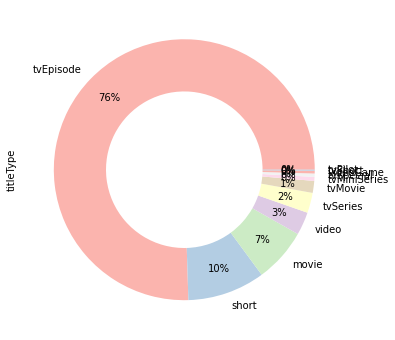

In [23]:
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
df_title_basics.titleType.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4), colors = colors)
plt.show()

Only 7% of the dataset are movies. Let's isolate them.

In [39]:
df_movie_basics = df_title_basics[df_title_basics['titleType'] == 'movie']
print("There are {} movies in the IMDb dataset".format(len(df_movie_basics)))
df_movie_basics = df_movie_basics.drop(columns = ['titleType', 'isAdult', 'endYear'])
df_movie_basics.head(3)

There are 626772 movies in the IMDb dataset


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1894,45,Romance
498,tt0000502,Bohemios,Bohemios,1905,100,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography"


In [40]:
df24 = df_titles_principal.merge(df_movie_basics, how = 'inner', on = 'tconst')
df24.head(3)

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance


In [41]:
#creates a file
picklefile = open('df24', 'wb')
#pickles the dataframe
pickle.dump(df24, picklefile)

In [42]:
picklefile = open('df24', 'rb')
#unpickle the dataframe
df24_retrieved = pickle.load(picklefile)
df24_retrieved

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance
3,tt0000009,4,nm0085156,director,\N,\N,male,Alexander Black,1859,Miss Jerry,Miss Jerry,1894,45,Romance
4,tt0000502,1,nm0215752,actor,\N,\N,male,Antonio del Pozo,\N,Bohemios,Bohemios,1905,100,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952500,tt9916706,4,nm3272130,actress,\N,\N,female,Ashwini Ekbote,1972,Dankyavar Danka,Dankyavar Danka,2013,\N,Comedy
2952501,tt9916730,1,nm6096005,actor,\N,\N,male,Devadhar Archit,\N,6 Gunn,6 Gunn,2017,116,\N
2952502,tt9916730,2,nm0059461,actor,\N,\N,male,Sunil Barve,\N,6 Gunn,6 Gunn,2017,116,\N
2952503,tt9916730,3,nm13233318,actor,\N,"[""Vishal""]",male,Ganesh Vasant Patil,\N,6 Gunn,6 Gunn,2017,116,\N


### 2.5 Title ratings <a class="anchor" id="section_2_5"></a>

In [43]:
f = gzip.open(data_folder_IMDB + '/title.ratings.tsv.gz', 'rb')
df_title_ratings=  pd.read_csv(f, sep='\t')
df_title_ratings.head(5)

,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1734
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


In [44]:
df_25 = df24_retrieved.merge(df_title_ratings, how = 'left', on = 'tconst')

In [45]:
#creates a file
picklefile = open('df_25', 'wb')
#pickles the dataframe
pickle.dump(df_25, picklefile)

### 2.6 Linking IMDb Ids to freebase movie Ids <a class="anchor" id="section_2_6"></a>

In [46]:
picklefile = open('df_25', 'rb')
#unpickle the dataframe
df25_retrieved = pickle.load(picklefile)
df25_retrieved.head(3)

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0


We query the mapping between freebase and IMDb IDs on movies

In [47]:
freebase_to_imdb = pd.read_csv('freebase_to_imdb.csv')
freebase_to_imdb.drop(columns = ['sitelink', 'item'], inplace = True)
freebase_to_imdb.head(3)

,freebaseID,IMDb_ID
0,/m/05cj_j,tt0074512
1,/m/0d1t3h,tt0079630
2,/m/0gt35,tt0031971


We obtained 102808 matches between freebase IDs and IMDb IDs.

In [48]:
df26 = df25_retrieved.merge(freebase_to_imdb, how = 'inner', left_on = 'tconst', right_on = 'IMDb_ID')
df26 = df26.drop(columns ='IMDb_ID')
df26 = df26.drop_duplicates()
final_df_imdb = df26

In [49]:
print('We kept {} movies and {} persons working on those movies'.format(final_df_imdb['tconst'].nunique(),final_df_imdb['nconst'].nunique()))

We kept 95116 movies and 182266 persons working on those movies


In [50]:
final_df_imdb.describe()

,ordering,averageRating,numVotes
count,732778.000000,662971.000000,6.629710e+05
mean,4.878602,6.167301,1.066603e+04
std,2.819658,1.087002,6.368150e+04
min,1.000000,1.000000,5.000000e+00
25%,2.000000,5.600000,8.400000e+01
50%,4.000000,6.300000,3.670000e+02
75%,7.000000,6.900000,1.798000e+03
max,10.000000,9.800000,2.659398e+06


In [51]:
final_df_imdb = final_df_imdb.merge(df_title_crew, how = 'left', on = 'tconst')

In [52]:
#creates a file
picklefile = open('final_df_imdb', 'wb')
#pickles the dataframe
pickle.dump(final_df_imdb, picklefile)

In [53]:
final_df_imdb

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,freebaseID,directors,writers
0,tt0000591,1,nm0906197,actor,\N,\N,male,Georges Wague,1874,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
1,tt0000591,2,nm0332182,actor,\N,\N,male,Henri Gouget,\N,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
2,tt0000591,3,nm1323543,actress,\N,\N,female,Christiane Mandelys,1873,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
3,tt0000591,4,nm1759558,actress,\N,\N,female,Gilberte Sergy,\N,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
4,tt0000591,5,nm0141150,director,\N,\N,male,Michel Carré,1865,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,nm0141150,nm0141150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732773,tt9898504,4,nm0474753,actress,\N,\N,female,Noor Kumalasari,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,nm0634777,\N
732774,tt9898504,6,nm1007470,actor,\N,\N,male,Puteh Lawak,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,nm0634777,\N
732775,tt9898504,7,nm0575397,actor,\N,"[""Datuk Bendahara""]",male,Shariff Medan,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,nm0634777,\N
732776,tt9898504,8,nm1403057,actor,\N,"[""Ayahanda Tengku Zainol""]",male,Ahmad Nisfu,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,nm0634777,\N


At the end of this pipeline, we have a notebook with for 95 116 movies matching freebase ids, the principal cast, their genders which have been queried, and some more information on the movie they play in. We also have shown the utility of the IMDb dataset to get access to the directors and writers genders which can add a lot to the analysis. We can see if having a movie written by a man or a woman in order reinforce certain characters stereotypes. Furthermore, we will show in the initial analyses that we can use the cinemagoer library to access a breakdown of movie reviews by gender, and so IMDb data can add a small bonus to the analysis by showing how woman opinion is represented in a popular rating website.

# 3. Initial analysis <a class="anchor" id="section3"></a>

### 3.1 Most common actions of characters in the summaries <a class="anchor" id="section_3_1"></a>
The dataframe characters_description allows us to identify action of characters in movies. We can then study, by gender, which are the most redundant actions.

In [24]:
## in this study we are interested in actor's actions
## let's remove some irrelevant words that we found
irrelevant_words = ['\'s', 'and', 'with', 'of', 'to', 'by', 'for', 'the', 'in', 'is', 'has', 'from', 'as',
                   'his', 'on', 'Dr.', 'The', 'a', 'Mr.', 'John', 'Miss', 'Mrs.', 'father', 'son', 'friend', 
                   'daughter', 'wife', 'mother', 'family', 'sister', 'brother', 'man', 'men', 'Captain', 
                   'Singh', 'Jack', 'King', 'girl', 'woman', 'girlfriend', 'Mary', 'husband', 'parents', 
                   'Lady', 'children', 'White', 'Queen', 'car', 'room']

conditions = (characters_descriptions['action']!='')

for irr_wrd in irrelevant_words:
    conditions = conditions&(characters_descriptions['action']!=irr_wrd)
    
act_df_treated = characters_descriptions[conditions]

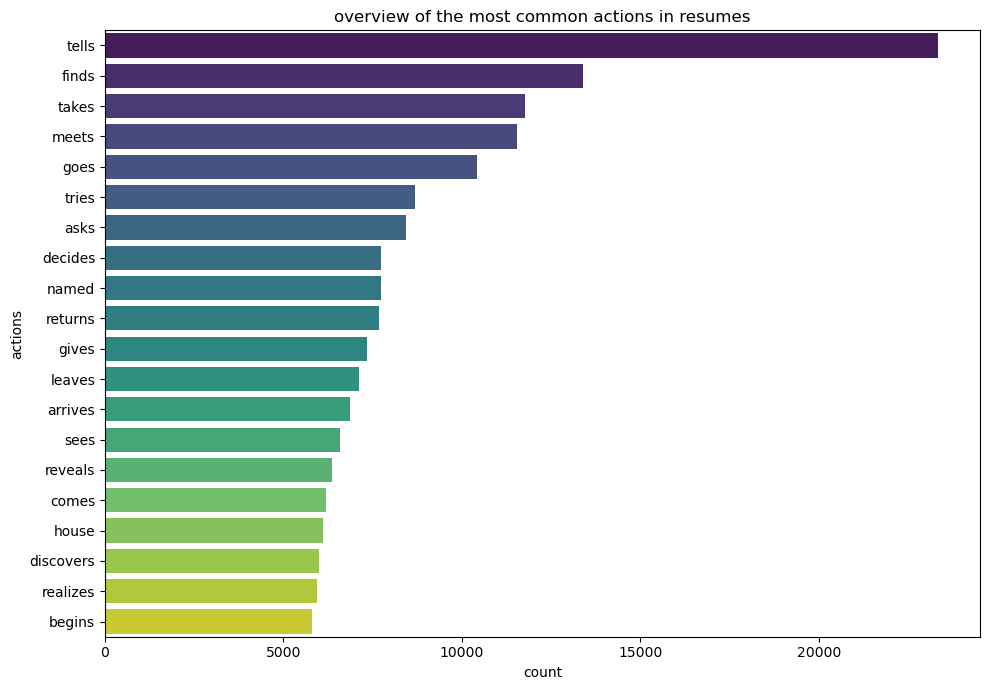

In [95]:
## let's have an overview of the most common actions of actors : 
most_common_actions = act_df_treated.groupby('action', as_index = False).count().sort_values('actor name', ascending = False).head(20)[['action', 'actor name']]
plt.figure(figsize = (10, 7))
sns.barplot(y= most_common_actions['action'], x = most_common_actions['actor name'], palette = 'viridis')
plt.title('overview of the most common actions in resumes')
plt.xlabel('count')
plt.ylabel('actions')
plt.tight_layout()

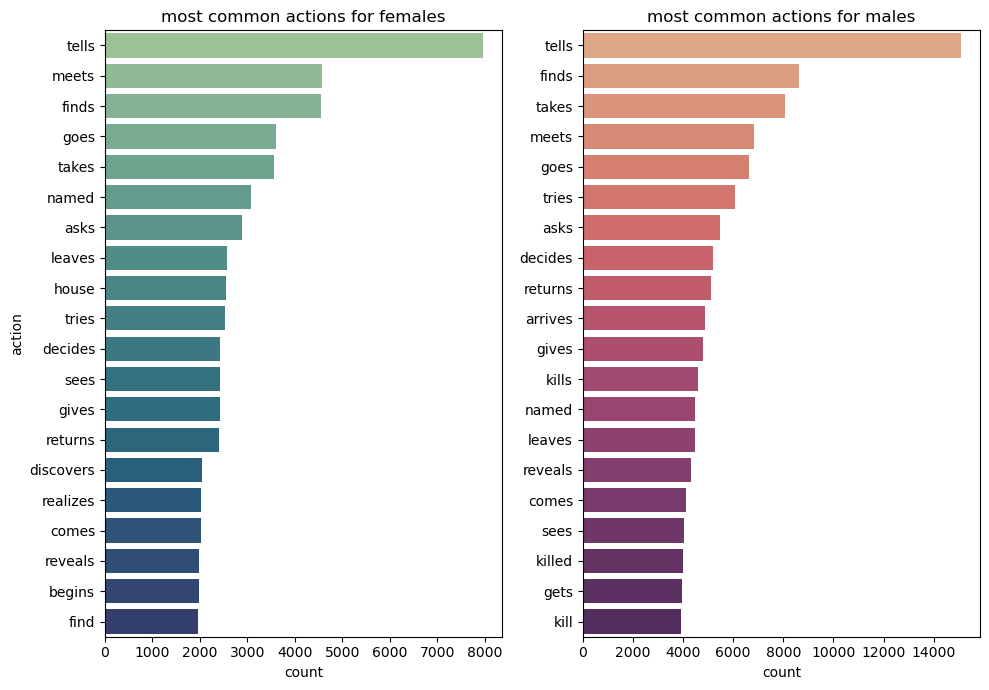

In [90]:
most_common_actions_M = act_df_treated[act_df_treated['actor gender']=='M'].groupby('action', as_index = False).count().sort_values('actor name', ascending = False).head(20)[['action', 'actor name']]
most_common_actions_F = act_df_treated[act_df_treated['actor gender']=='F'].groupby('action', as_index = False).count().sort_values('actor name', ascending = False).head(20)[['action', 'actor name']]
f, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 7), sharex = False)
sns.barplot(ax=ax[0], y= most_common_actions_F['action'], x = most_common_actions_F['actor name'], palette = 'crest')
sns.barplot(ax=ax[1], y= most_common_actions_M['action'], x = most_common_actions_M['actor name'], palette = 'flare')
ax[0].set_title('most common actions for females')
ax[1].set_title('most common actions for males')
ax[0].set_xlabel('count')
ax[1].set_xlabel('count')
ax[1].set_ylabel(None)
plt.tight_layout()

Looking at those graphs, it seems that there are a lot of actions in common for both men and women. But it seems that these common actions are really basic. What interest us is : what about the stereotyped actions like 'marry' or 'kill' for example ?

*NB : x scales are not the same for ax[0] and ax[1]*

In [40]:
## Now let's separate the data set into one for males and one for females.
## We will make some more comparisons
male_description = act_df_treated[act_df_treated['actor gender']=='M']
female_description = act_df_treated[act_df_treated['actor gender']=='F']

We are interested her in the 100 most common actions for males, and for females, but separately this time. 

In [41]:
## let's take the 100 most common actions for males also for females
## We will look at actions that are common for both genders and the ones that are only 
## for on of them
head_males = male_description.groupby('action', as_index=False).count().sort_values('actor name', ascending = False).head(100)
head_females = female_description.groupby('action', as_index=False).count().sort_values('actor name', ascending = False).head(100)

Men and women share 87 actions over their 100 most common actions.


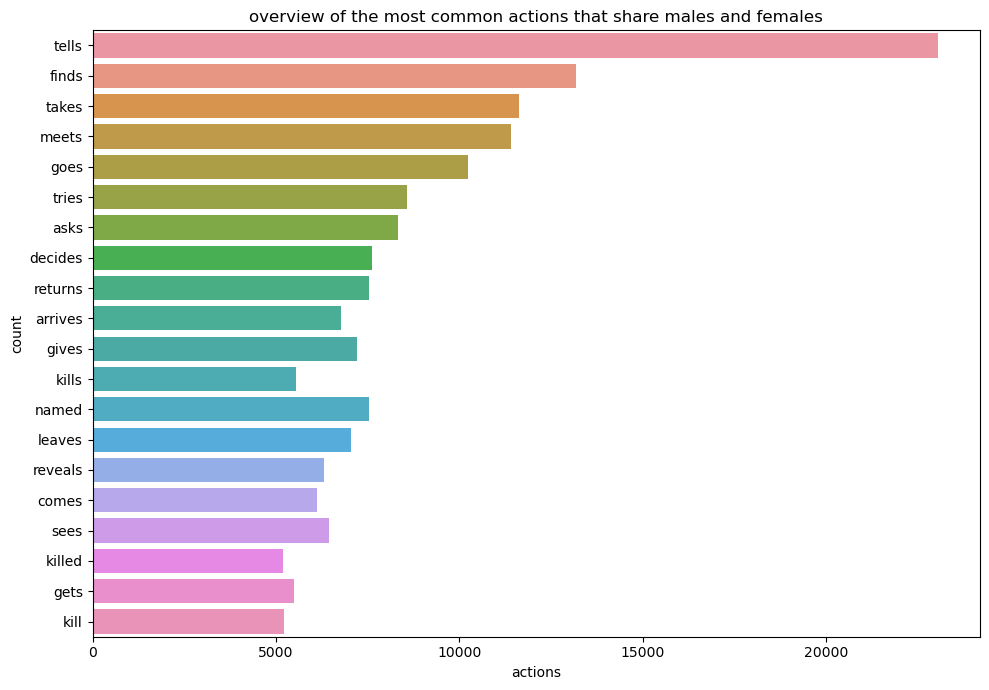

In [45]:
## we merge them on their common most common words :
merge_df = head_males.merge(head_females, how = 'inner', on = 'action', suffixes=('_M', '_F'))
plt.figure(figsize = (10, 7))
sns.barplot(y= merge_df.head(20)['action'], x = merge_df.head(20)['actor name_M']+merge_df.head(20)['actor name_F'])
plt.title('overview of the most common actions that share males and females')
plt.xlabel('count')
plt.ylabel('actions')
#plt.xticks(rotation=30)
plt.tight_layout()
## on the 100 most common actions for men and female, how many are shared by both gender ?
print('Men and women share ' + str(merge_df.shape[0]) + ' actions ' + 'over their 100 most common actions.')

*For the next milestone, we will aggregate words that have the same radical, for example "kill", "kills", "killed". This will significatively the graph*

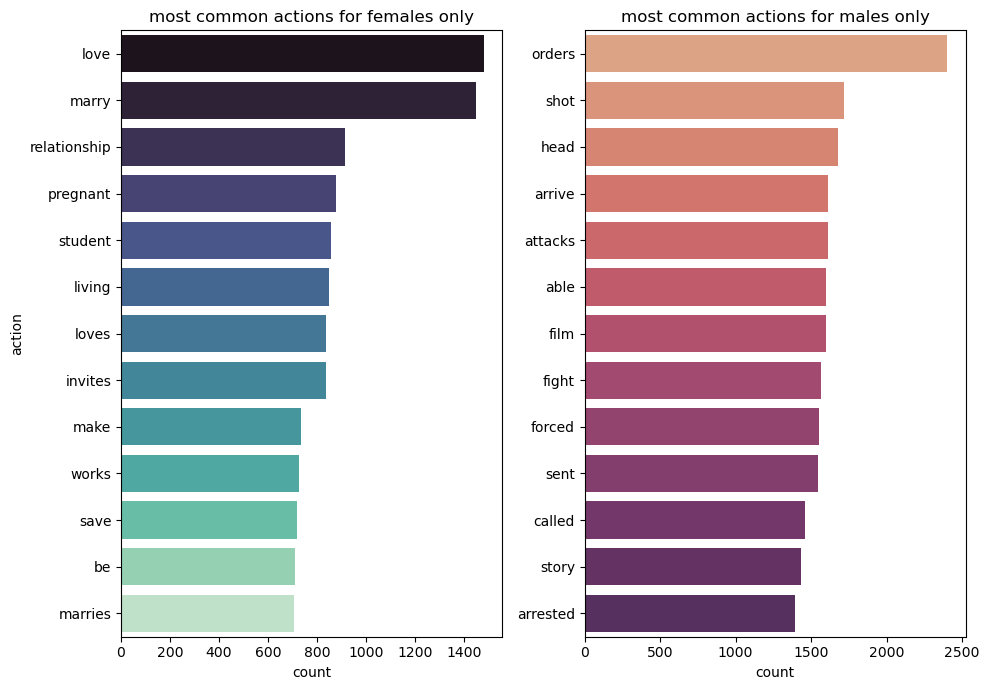

In [97]:
## Now let's look at the actions that they doesn't share
top_actions_M_not_in_top_actions_F = pd.concat([head_males[['action', 'actor name']].rename(columns={'actor name': "actor name_M"}), merge_df[['action', 'actor name_M']], merge_df[['action', 'actor name_M']]]).drop_duplicates(keep=False)
top_actions_F_not_in_top_actions_F= pd.concat([head_females[['action', 'actor name']].rename(columns={'actor name': "actor name_F"}), merge_df[['action', 'actor name_F']], merge_df[['action', 'actor name_F']]]).drop_duplicates(keep=False)

f, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 7), sharex = False)
sns.barplot(ax=ax[0], y= top_actions_F_not_in_top_actions_F.head(13)['action'], x = top_actions_F_not_in_top_actions_F.head(13)['actor name_F'], palette = 'mako')
sns.barplot(ax=ax[1], y= top_actions_M_not_in_top_actions_F.head(13)['action'], x = top_actions_M_not_in_top_actions_F.head(13)['actor name_M'], palette = 'flare')
ax[0].set_title('most common actions for females only')
ax[1].set_title('most common actions for males only')
ax[0].set_xlabel('count')
ax[1].set_xlabel('count')
ax[1].set_ylabel(None)
plt.tight_layout()

*NB : x scales are not the same for ax[0] and ax[1]*

Here the result we found are very interesting. 

### 3.2 Are women younger in cinema ? <a class="anchor" id="section_3_2"></a>

In [18]:
world = df_merged_meta.copy()

We only keep :
- Films released between 1950 and 2010
- Raws with a "correct" actor age, i.e. positive

In [19]:
init_len = world.shape[0]
world.query('`Movie release date` >= 1950 and `Movie release date` <= 2010 ', inplace=True)
world.query('`Actor age at movie release` > 0', inplace=True)
perc = world.shape[0]/init_len *100
print("%.2f" % perc, '% of entries are exploitable (',world.shape[0],'entries )')

#Change format :
world['Movie countries'] = world['Movie countries'].astype('str')
world['Movie genres'] = world['Movie genres'].astype('str')

87.34 % of entries are exploitable ( 253919 entries )


#### Split the world in 3 regions:
- Usa   : Hollywood
- India : Bollywood
- West Europe (including France, Italy, Germany, Spain, Luxembourg, Netherlands, United kingdom)

In [20]:
#Split it into three regions
usa_df = world[world['Movie countries'].str.contains('United State')]
print('usa entries :',usa_df.shape[0])
india_df = world[world['Movie countries'].str.contains('India')]
print('india entries :',india_df.shape[0])
west_europe = ['France','Italy','German','Spain','Luxembourg','Netherlands','United kingdom'] 
west_europe_df = world[world['Movie countries'].str.contains('|'.join(west_europe),case=False)]
print('west europe entries :',west_europe_df.shape[0])

usa entries : 142167
india entries : 30076
west europe entries : 60544


#### Evolution of actor / actress age

In [23]:
#Usa
usa_men = usa_df.query('`Actor gender` == "M"')
usa_women = usa_df.query('`Actor gender` == "F"')
stats_by_year_usa_men = usa_men.groupby(usa_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_usa_women = usa_women.groupby(usa_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

#India
india_men = india_df.query('`Actor gender` == "M"')
india_women = india_df.query('`Actor gender` == "F"')
stats_by_year_india_men = india_men.groupby(india_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_india_women = india_women.groupby(india_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

#Europe
europe_men = west_europe_df.query('`Actor gender` == "M"')
europe_women = west_europe_df.query('`Actor gender` == "F"')
stats_by_year_europe_men = europe_men.groupby(europe_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_europe_women = europe_women.groupby(europe_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

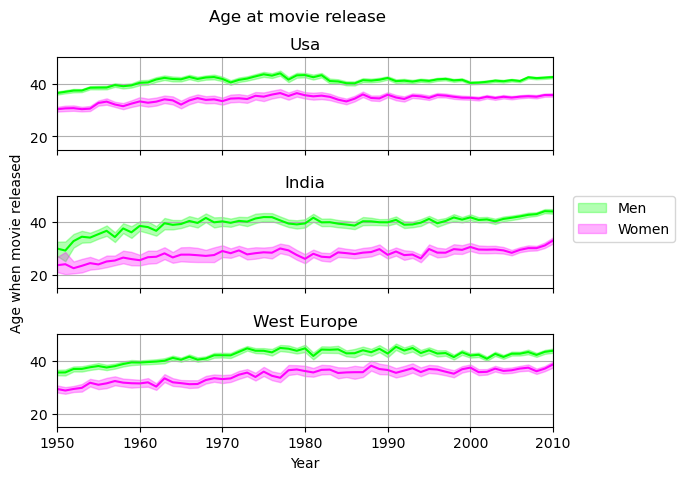

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Age at movie release')
fig.subplots_adjust(hspace=.5)
ax1.set_xlim([1950,2010])
ax1.set_ylim([15,50])
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)


#USA :
ax1.set_title('Usa')
ax1.fill_between(stats_by_year_usa_men.index, stats_by_year_usa_men.lower_err_age,
                 stats_by_year_usa_men.upper_err_age, alpha = 0.3, color = 'lime', label='Men')
ax1.plot(stats_by_year_usa_men.average_age, color = 'lime')

ax1.fill_between(stats_by_year_usa_women.index, stats_by_year_usa_women.lower_err_age,
                 stats_by_year_usa_women.upper_err_age, alpha = 0.3, color = 'magenta', label='Women' )
ax1.plot(stats_by_year_usa_women.average_age, color = 'magenta')




#INDIA :
ax2.set_title('India')
ax2.fill_between(stats_by_year_india_men.index, stats_by_year_india_men.lower_err_age,
                 stats_by_year_india_men.upper_err_age, alpha = 0.3, color = 'lime')
ax2.plot(stats_by_year_india_men.average_age, color = 'lime', label='Men')

ax2.fill_between(stats_by_year_india_women.index, stats_by_year_india_women.lower_err_age,
                 stats_by_year_india_women.upper_err_age, alpha = 0.3, color = 'magenta', label='Women')
ax2.plot(stats_by_year_india_women.average_age, color = 'magenta')
ax2.set_ylabel('Age when movie released')

#EUROPE :
ax3.set_title('West Europe')
ax3.fill_between(stats_by_year_europe_men.index, stats_by_year_europe_men.lower_err_age,
               stats_by_year_europe_men.upper_err_age, alpha = 0.3, color = 'lime', label='Men')
ax3.plot(stats_by_year_europe_men.average_age, color = 'lime')

ax3.fill_between(stats_by_year_europe_women.index, stats_by_year_europe_women.lower_err_age,
                 stats_by_year_europe_women.upper_err_age, alpha = 0.3, color = 'magenta', label='Women')
ax3.plot(stats_by_year_europe_women.average_age, color = 'magenta')
ax3.set_xlabel('Year')

plt.legend(loc=(1.04, 2))

In all three major regions, the average women's age is consistently lower than that of men. Thus, actresses were and still are younger than actors in films.

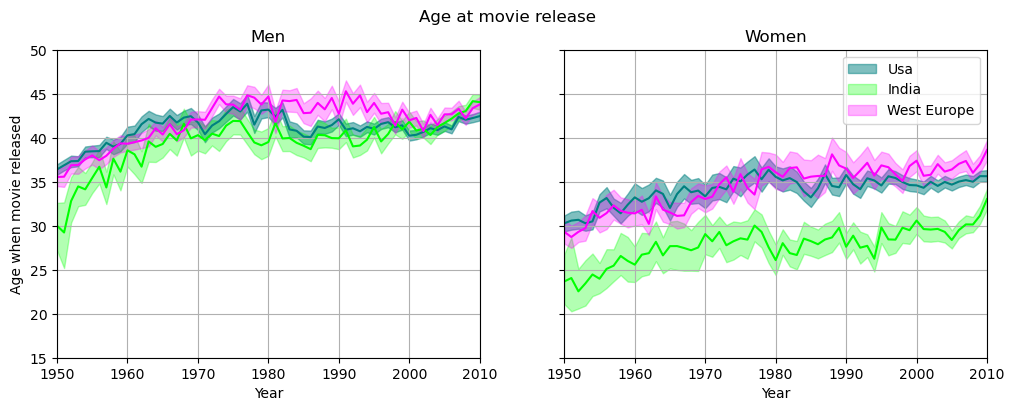

In [25]:
#Plot :
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, sharex=True, figsize=(12, 4))
fig.suptitle('Age at movie release')
fig.subplots_adjust(hspace=.1)
ax1.set_xlim([1950,2010])
ax1.set_ylim([15,50])
ax1.grid(True)
ax2.grid(True)
ax1.set_title('Men')
ax2.set_title('Women')
ax1.set_xlabel('Year')
ax1.set_ylabel('Age when movie released')
ax2.set_xlabel('Year')


#USA :

ax1.fill_between(stats_by_year_usa_men.index, stats_by_year_usa_men.lower_err_age,
                 stats_by_year_usa_men.upper_err_age, alpha = 0.5, color = 'teal')
ax1.plot(stats_by_year_usa_men.average_age, color = 'teal')

ax2.fill_between(stats_by_year_usa_women.index, stats_by_year_usa_women.lower_err_age,
                 stats_by_year_usa_women.upper_err_age, alpha = 0.5, color = 'teal', label='Usa')
ax2.plot(stats_by_year_usa_women.average_age, color = 'teal')



#INDIA :

ax1.fill_between(stats_by_year_india_men.index, stats_by_year_india_men.lower_err_age,
                 stats_by_year_india_men.upper_err_age, alpha = 0.3, color = 'lime', label='India')
ax1.plot(stats_by_year_india_men.average_age, color = 'lime')

ax2.fill_between(stats_by_year_india_women.index, stats_by_year_india_women.lower_err_age,
                 stats_by_year_india_women.upper_err_age, alpha = 0.3, color = 'lime', label='India')
ax2.plot(stats_by_year_india_women.average_age, color = 'lime', )


#EUROPE :

ax1.fill_between(stats_by_year_europe_men.index, stats_by_year_europe_men.lower_err_age,
               stats_by_year_europe_men.upper_err_age, alpha = 0.3, color = 'magenta')
ax1.plot(stats_by_year_europe_men.average_age, color = 'magenta')

ax2.fill_between(stats_by_year_europe_women.index, stats_by_year_europe_women.lower_err_age,
                 stats_by_year_europe_women.upper_err_age, alpha = 0.3, color = 'magenta', label='West Europe')
ax2.plot(stats_by_year_europe_women.average_age, color = 'magenta')

plt.legend()


We can see that men's age follow the same trend with no difference for the three differents regions. However regarding women's ages, India has a difference compared to the two other areas and so Bollywood employs slightly younger women.

### 3.3 Differences between genres <a class="anchor" id="section_3_3"></a>

In [74]:
df_genre = pd.DataFrame(df_char_meta["Actor gender"])
df_genre = df_genre.dropna(subset=['Actor gender'])

df_genre["Actor age at release date"] = df_char_meta["Actor age at movie release"]
df_genre = df_genre.dropna(subset=['Actor age at release date'])

df_genre["Freebase movie ID"] = df_char_meta["Freebase movie ID"]
df_genre = pd.merge(df_genre, df_movie_meta[["Freebase movie ID", "Movie release date", "Movie countries", "Movie genres"]], on="Freebase movie ID")
#df_plus = df_plus.dropna(subset=['Movie box office revenue'])
df_genre["Movie release date"] = pd.to_datetime(df_genre["Movie release date"])
df_genre["Movie release date"] = df_genre["Movie release date"].dt.year

df_genre = df_genre.query("`Actor age at release date` > 0")
df_genre = df_genre.query("`Movie release date` > 1915")

df_genre["Main genre"] = df_genre['Movie genres'].apply(lambda x:x[0] if len(x) else "")
del df_genre["Movie genres"]

In [75]:
df_drama = df_genre[df_genre["Main genre"] == "Drama"]
df_comedy = df_genre[df_genre["Main genre"] == "Comedy"]
df_romance = df_genre[df_genre["Main genre"] == "Romance Film"]
df_action = df_genre[df_genre["Main genre"] == "Action"]
df_BW = df_genre[df_genre["Main genre"] == "Black-and-white"]
df_horror = df_genre[df_genre["Main genre"] == "Horror"]

In [119]:
df_age = pd.DataFrame(df_drama.groupby(by="Actor gender").mean()["Actor age at release date"])
df_temp = pd.DataFrame(df_action.groupby(by="Actor gender").mean()["Actor age at release date"])
df_age = pd.concat([df_age, df_temp], axis = 1)
df_temp = pd.DataFrame(df_BW.groupby(by="Actor gender").mean()["Actor age at release date"])
df_age = pd.concat([df_age, df_temp], axis = 1)
df_temp = pd.DataFrame(df_romance.groupby(by="Actor gender").mean()["Actor age at release date"])
df_age = pd.concat([df_age, df_temp], axis = 1)
df_temp = pd.DataFrame(df_comedy.groupby(by="Actor gender").mean()["Actor age at release date"])
df_age = pd.concat([df_age, df_temp], axis = 1)
df_temp = pd.DataFrame(df_horror.groupby(by="Actor gender").mean()["Actor age at release date"])
df_age = pd.concat([df_age, df_temp], axis = 1)
df_age.columns=["drama", "action", "B&W", "romance", "comedy", "horror"]
df_age = df_age.transpose()
df_age["Age difference"] = df_age["M"]-df_age["F"]
df_age.index.names = ['Movie gender']
df_age.columns.names=[""]
df_age

,F,M,Age difference
Movie gender,,,
drama,33.489866,39.965172,6.475306
action,29.186372,40.671419,11.485047
B&W,28.257937,34.162679,5.904743
romance,30.863814,38.489068,7.625254
comedy,33.415680,40.681688,7.266008
horror,31.074741,39.823761,8.749020


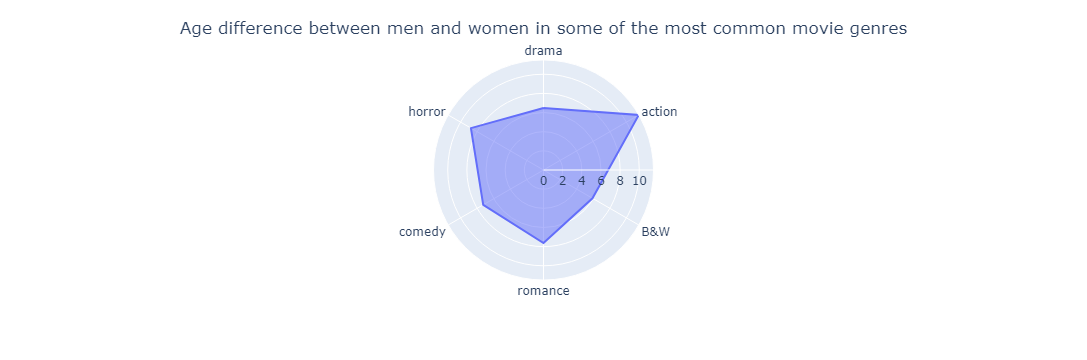

In [108]:
fig = px.line_polar(df_age, r='Age difference', theta=["drama", "action", "B&W", "romance", "comedy", "horror"], line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
    title = {
        "text": "Age difference between men and women in some of the most common movie genres",
        "y":0.94,
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
fig.show()

We observe that the age difference between men and women depends strongly on the movie genre in which they are playing. Action movies show the higher difference for the displayed, and B&W the least.

### 3.4 Difference in importance of movie roles women and men get <a class="anchor" id="section_3_4"></a>
We would like to know if men get more key roles than women in cinema in general.
To do so, we first looked on the web (imdb, kaggle, etc.) if we could get datasets with classification of main actors for some movies. But we didn't found a dataset that was big enough. This question is very important for us, and we think it could be very relevant to have an overview of actors importance in movies, by gender. Consequently, we decided to make, for some movies, the ranking of characters using the number of occurence of their name in the summary. 

In [5]:
## To do so, we will use :
## •plot_summaries
## •character_md
character_md = df_char_meta.copy()

In [8]:
## let's merge summaries with character_md
char_summaries = character_md.merge(plot_summaries, on = 'Wikipedia movie ID', how ='inner')
char_summaries.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie release date,character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,summary
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,"Set in the second half of the 22nd century, th..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,"Set in the second half of the 22nd century, th..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,"Set in the second half of the 22nd century, th..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,"Set in the second half of the 22nd century, th..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,"Set in the second half of the 22nd century, th..."


In [9]:
## some characters name are NaN values, let's remove them, as well as NaN summaries
char_summaries = char_summaries.dropna(subset=['character name', 'summary'])

In [10]:
## We define a function that count the number of occurence of a character name in a resume
## it also take into account that sometimes the character is called by a part of its name.
## example : Jericho for Sgt Jericho Butler 
## the goal of this function is then to by used as an apply on each row of merged_df

def counter(char_name, resume):
    char_list = char_name.split()
    counter = 0
    words_to_remove = ['the', 'The', 'Sgt', 'Big', 'nan', 'NaN', 'in']
    for wtr in words_to_remove:
        try:
            char_list.remove(wtr)
        except:
            counter = 0
    for char in char_list:
        counter += resume.count(char)
    return counter

In [11]:
char_summaries['name occurence in summary'] = char_summaries.apply(lambda row : counter(str(row['character name']), row['summary']), axis = 1)

In [12]:
## here we sort character names for each movie by their number of occurence in the summary
char_summaries.sort_values(['Wikipedia movie ID', 'name occurence in summary'], ascending = False).head(20)[['Wikipedia movie ID', 'character name', 'name occurence in summary', 'Actor gender', ]]

,Wikipedia movie ID,character name,name occurence in summary,Actor gender
293914,37501922,John Hunter,1,M
293915,37501922,Craig Murphy,0,F
307483,37478048,Ajay,5,M
47027,37373877,Beth Patterson,0,F
47029,37373877,Jennifer Jones,0,F
229443,36956792,Angus MacMorrow,18,M
229441,36956792,Old Angus,17,M
229455,36956792,Young Angus,17,M
229439,36956792,Lewis Mowbray,6,M
229452,36956792,Captain Hamilton,5,M


As we can see, for each movie (movie ID), we have for each character the number of occurence of his/her name in the summary. This will give us some insight of how important are roles obtained by males and females in movies.

In [14]:
#We remove all rows with zero occurences in the resume
char_with_role = char_summaries[(char_summaries['name occurence in summary']!=0)&(char_summaries['name occurence in summary']<500)]

In [15]:
char_with_role[char_with_role['Actor gender']=='M'][['name occurence in summary']].describe()

,name occurence in summary
count,45691.000000
mean,8.266289
std,10.295789
min,1.000000
25%,2.000000
50%,5.000000
75%,11.000000
max,485.000000


In [16]:
char_with_role[char_with_role['Actor gender']=='F'][['name occurence in summary']].describe()

,name occurence in summary
count,26050.000000
mean,7.167678
std,8.769898
min,1.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,349.000000


As can be seen, male characters are slightly more cited than their females counterparts. 

### 3.5 Are IMDb ratings representing somewhat more male or female opinion on movie ? <a class="anchor" id="section_3_5"></a>

We show here that we can access the breakdown of movie ratings by gender, which can be useful to the analysis. Indeed, we look at how genders are represented in cinema, and seeing how their opinion is represented on a popular website like IMDb can be an interesting persepective. We study quickly the top 250 movies as an initial analysis.

In [54]:
from imdb import IMDb
ia = IMDb()

In [55]:
top250 = ia.get_top250_movies()

df = pd.DataFrame()
ids = []
# Iterate through the first 20 movies in the top 250
for movie_count in range(0, 250):
    # First, retrieve the movie object using its ID
    movie = ia.get_movie(top250[movie_count].movieID, 'vote details')
    a = pd.DataFrame.from_dict(movie.get('demographics'))
    movie = ia.get_movie(top250[movie_count].movieID) # The identifier is simply tconst without "tt"
    ids.append(str(movie.get('title')) + " votes")
    ids.append(str(movie.get('title')) + " ratings")
    
    df = df.append(a)

250


Text(0, 0.5, 'Number of movies')

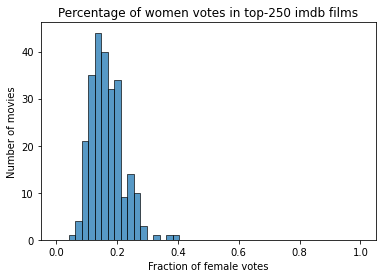

In [56]:
df = df.set_index(np.array(ids))
df_votes = df[df['ttrt fltr imdb users']>10]
print(len(df_votes))
df_votes['percent_women'] = df_votes['ttrt fltr females']/( df_votes['ttrt fltr males'] +  df_votes['ttrt fltr females'])

sns.histplot(df_votes['percent_women'], binrange = (0,1))
plt.title('Percentage of women votes in top-250 imdb films')
plt.xlabel('Fraction of female votes')
plt.ylabel('Number of movies')

In [57]:
df_votes.describe()

,ttrt fltr imdb users,ttrt fltr aged under 18,ttrt fltr aged 18 29,ttrt fltr aged 30 44,ttrt fltr aged 45 plus,ttrt fltr males,ttrt fltr males aged under 18,ttrt fltr males aged 18 29,ttrt fltr males aged 30 44,ttrt fltr males aged 45 plus,ttrt fltr females,ttrt fltr females aged under 18,ttrt fltr females aged 18 29,ttrt fltr females aged 30 44,ttrt fltr females aged 45 plus,ttrt fltr top 1000 voters,ttrt fltr us users,ttrt fltr non us users,percent_women
count,2.500000e+02,250.000000,250.000000,2.500000e+02,250.000000,2.500000e+02,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,2.500000e+02,250.000000
mean,6.352836e+05,277.184000,83823.984000,2.550473e+05,74302.768000,3.635374e+05,202.168000,65042.308000,210051.052000,61605.408000,74069.324000,52.976000,16110.184000,41201.82000,11254.356000,715.416000,144255.252000,4.163558e+05,0.166873
std,5.133924e+05,284.397803,73289.817968,2.063208e+05,52377.731205,2.890791e+05,206.932938,56655.082199,170154.110857,43570.475899,62073.731339,52.407189,15142.401815,35377.13379,8077.855316,156.816481,114511.910655,3.330848e+05,0.053247
min,3.006200e+04,13.000000,2231.000000,1.240700e+04,1617.000000,2.061600e+04,6.000000,1986.000000,11212.000000,1451.000000,1711.000000,5.000000,208.000000,679.00000,129.000000,108.000000,5674.000000,2.173100e+04,0.042902
25%,2.214622e+05,77.000000,25061.000000,8.541875e+04,31942.000000,1.215330e+05,54.000000,18652.000000,67796.250000,26551.500000,22810.250000,17.000000,3780.000000,11864.75000,4846.250000,626.250000,47930.250000,1.432375e+05,0.128917
50%,4.906885e+05,164.000000,64072.500000,1.849370e+05,64662.000000,2.788975e+05,122.500000,50688.000000,155002.000000,53793.000000,57989.500000,33.000000,10835.500000,32324.00000,9518.500000,746.000000,119064.500000,3.288005e+05,0.161445
75%,9.541362e+05,398.750000,126607.000000,3.757280e+05,104674.250000,5.337785e+05,295.750000,94536.000000,313899.750000,87291.500000,113955.500000,66.750000,25193.500000,64804.50000,15973.000000,841.500000,212163.000000,6.147090e+05,0.196589
max,2.661909e+06,1689.000000,374587.000000,1.060802e+06,273938.000000,1.490179e+06,1158.000000,300630.000000,886560.000000,221705.000000,295933.000000,350.000000,76429.000000,165999.00000,45994.000000,931.000000,619747.000000,1.669367e+06,0.394324


Women contributes to only 16.9% of the ratings in the top IMDb movies. Not a single of these movies have more ratings coming from women. The opinion represented on IMDb is mainly male opinion, at least for the top rated movies.